# Spectra

## Spectral analysis of timeseries

Turbulence is associated with different scales, which interact in a complex manner and to investigate them spectra can be examined. Thereby, the measurements are transformed from time to frequency domain. The most common approach is to represent the timeseries with a series of sine and cosine function (with different frequencies), which is referred to as Fourier analysis. A numerical optimized way to calculate the Fourier transformation is to use Fast Fourier Transform (FFT, in rbase: `fft`). However, periodicity is not always a suitable assumption, such that other basis functions and approaches might be more applicable. With a wavelet transform information in time and frequency domain is retained and different wavelet basis functions (e.g., Morlet wavelets or Haar-wavelets) allow to represent localized and non-periodic behaviour (`WaveletComp::wt.image`). A very practical discrete wavelet transform is multiresolution decomposition (MRD, @Vickers2003, `Reddy::calc_mrd`), which is routinley applied in the analysis of eddy-covariance data (see details below). <br>
A related method used for flux calculations from eddy-covariance data is based on Ogives, that is a cumulative frequency distribution, i.e. the sum of the cospectral energy. @Sievers2015 developed an Ogive optimization, which allows to disentangle low frequency contributions on flux estimates. This approach is particular relevant under low-flux conditions, e.g. with changing signs in one averaging interval. The low frequency contributions are generally associated with non-local features, e.g. topography, while high-frequency contributions are local.

**Quick overview:** <br>
- Fast Fourier Transform FFT (rbase: `fft`, `spectrum`)
- Wavelets (`WaveletComp::wt.image`)
- Multiresolution decomposition MRD (`Reddy::calc_mrd`)
- Ogives (`Reddy::calc_ogive`)

In [1]:
#loading Reddy package
install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE,quiet=TRUE)
library(Reddy)

#ec data files
dir_in="../data/ec-data_10Hz_raw"
files=list.files(dir_in,full.names=TRUE)
nf=length(files)

i=8 #select a file
tmp=read.table(files[i],sep=",",header=T)

## Frequency spectrum with FFT
The rbase function `spectrum` calculates the spectrum based on FFT and plots by default an associated periodigram. 

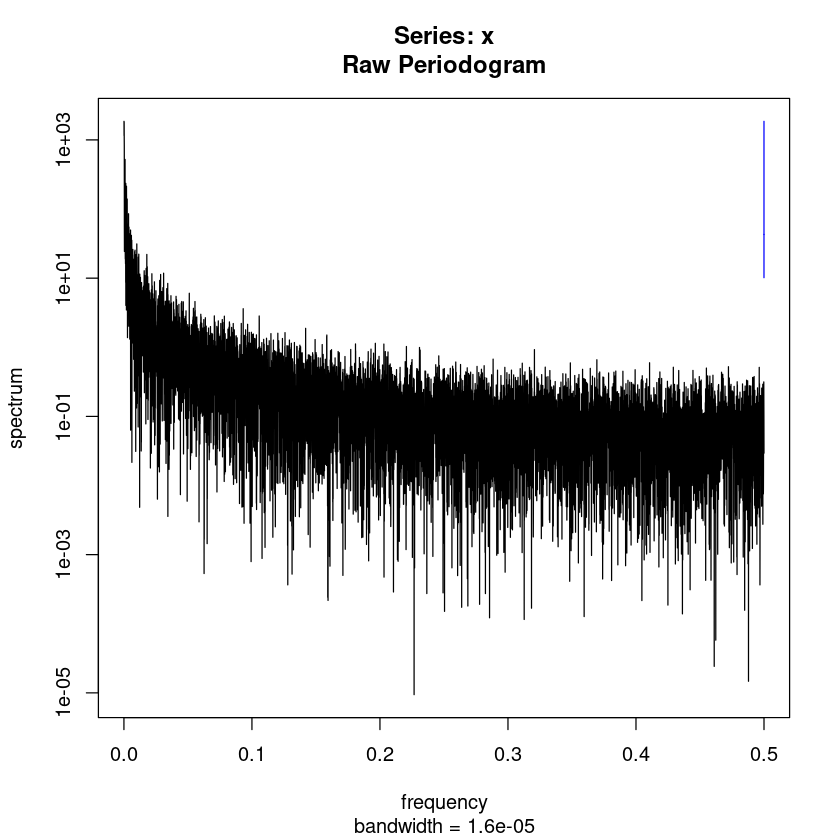

In [2]:
spectrum(tmp$u_m.s)

However, to systematically investigate spectral density and reduce the noise, it is recommended to apply binning (i.e., averaging over frequency intervals), which can be done with the function `Reddy::calc_spectrum1D` (using `rbase::fft()`). The resulting averaged spectra can then be compared to theoretical slopes. In homogeneous and isotropic turbulence a spectral slope of -5/3 follows from theoretical considerations (Kolmogorovs energy cascade), which is usually used as visual comparison. Deviations from this -5/3-slope indicate that either more energy (steeper slope) or less energy (weaker slope) is dissipated, which can have various reasons, e.g. turbulence anisotropy or energy injections.

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1 x value <= 0 omitted from logarithmic plot”


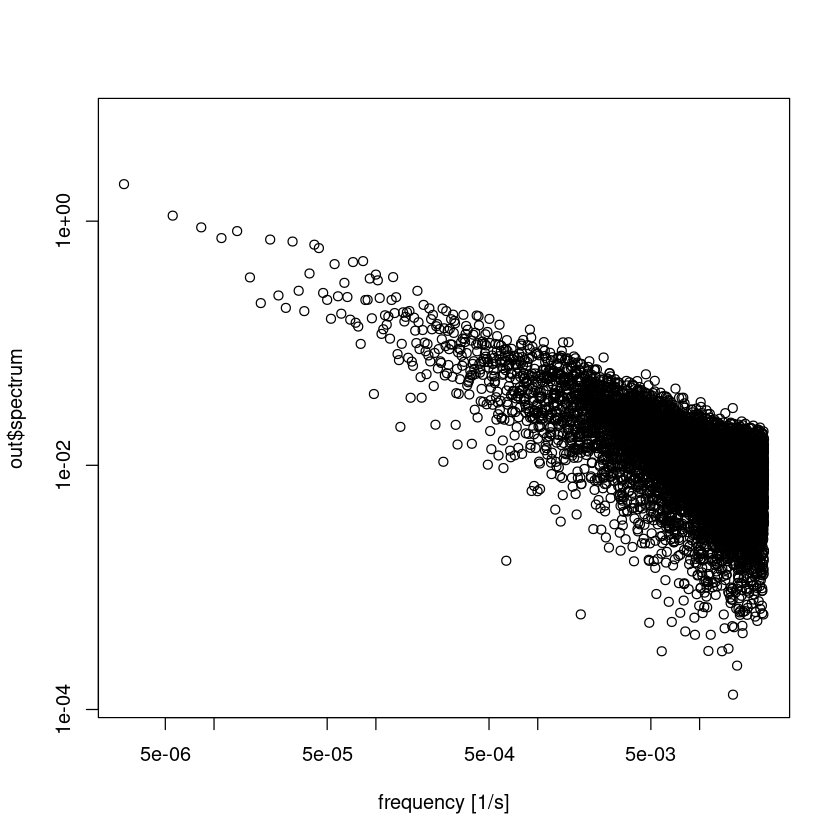

In [3]:
spectrum_u = calc_spectrum1D(tmp$u_m.s)

## Multiresolution decomposition (MRD)
Multiresolution decomposition (MRD) is a method to characterize the timescale dependence of variances (spectrum) or covariances (cospectrum) and to find scale gaps between turbulent and submeso-scale motions. It uses Haar wavelets, which have the advantage over Fourier analysis that no periodicity is assumed. For this, the time series is step-by-step cut in half, as visualized in the figure.

<img src="../figures/schema/mrd_schema.png" width=600 />


### Calculating multiresolution decomposition with `calc_mrd`

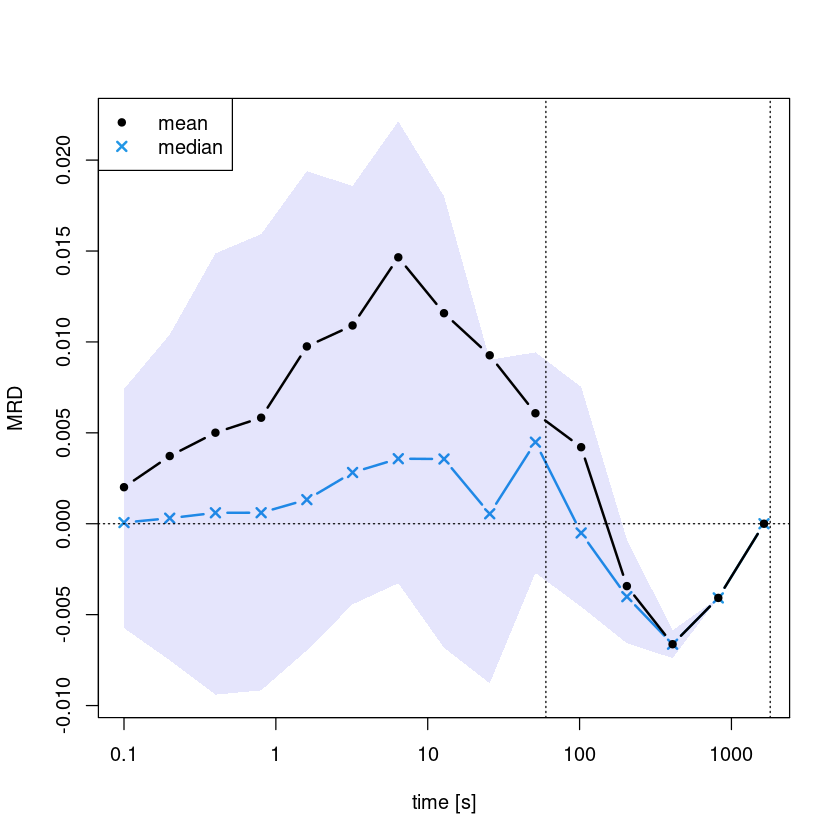

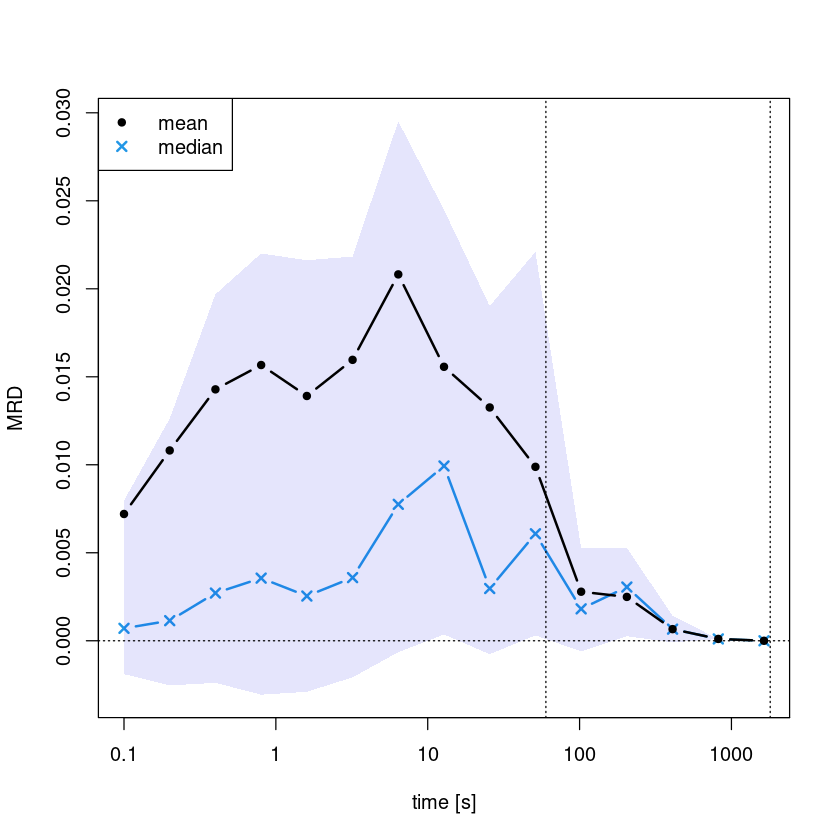

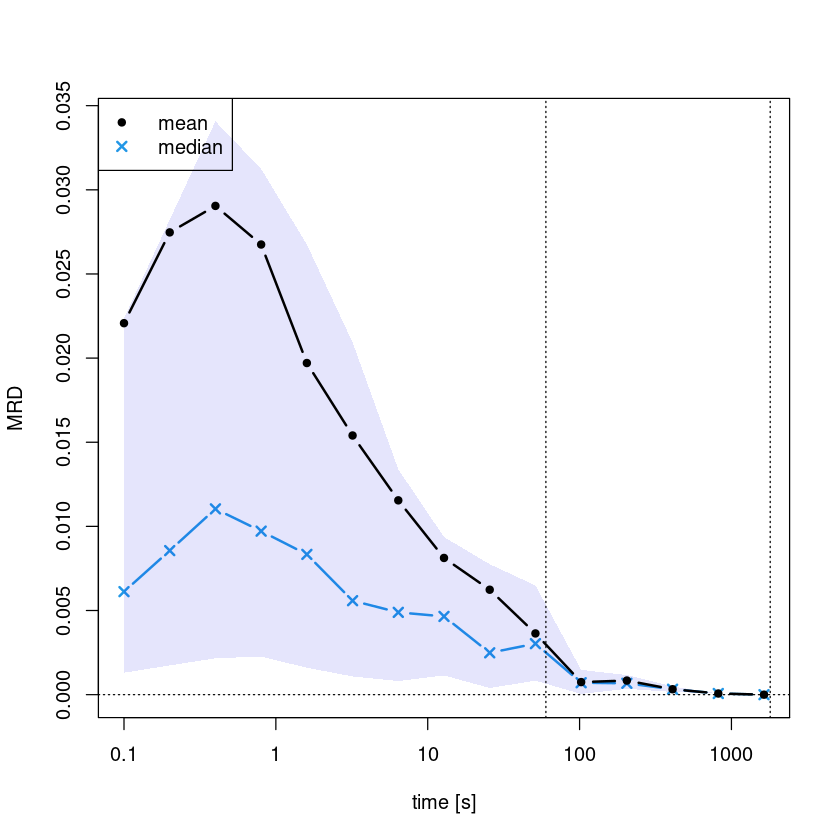

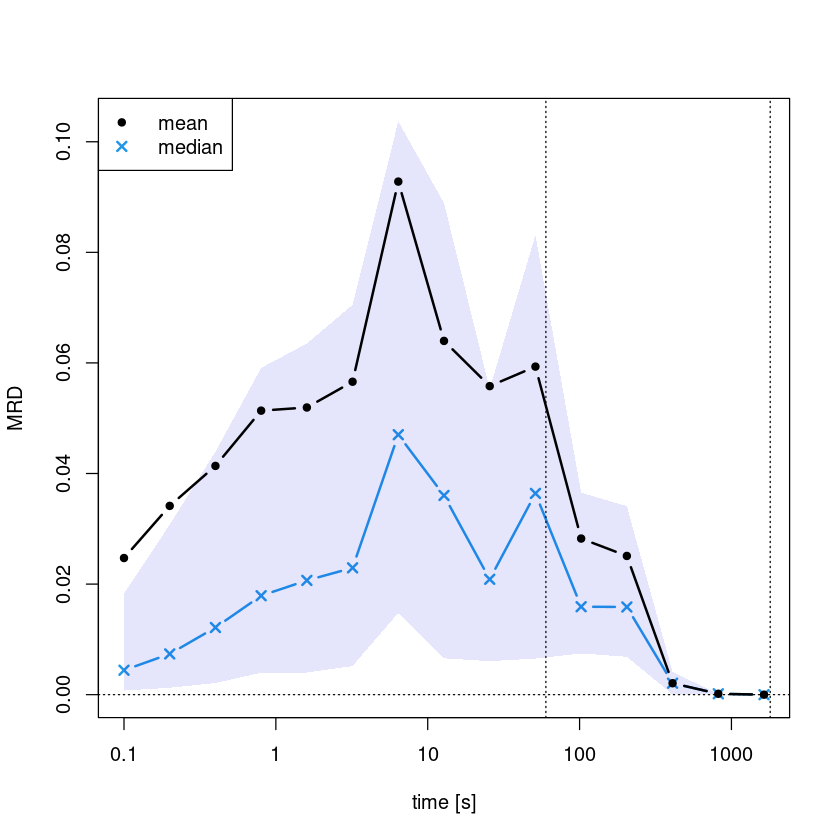

In [4]:
#cospectra
mrd_uw=calc_mrd(tmp$u_m.s,tmp$w_m.s,time_res=0.1) #momentum flux
mrd_Tw=calc_mrd(tmp$T_degC,tmp$w_m.s,time_res=0.1) #sensible heat flux

#spectra
mrd_ww=calc_mrd(tmp$w_m.s,tmp$w_m.s,time_res=0.1) #vertical veloctiy
mrd_TT=calc_mrd(tmp$T_degC,tmp$T_degC,time_res=0.1) #temperature

The function returns a dataframe containing index, exponent $m$, scale (i.e. $2^{m}$), time [s], mean, median, 25% and 75% quartiles as columns. The number of rows is given by $M$ fulfilling $2^M \le $ #measurements.

In [5]:
#look into output
mrd_uw

index,m,scale,time,mean,median,q25,q75
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14,16384,1638.4,-8.838739e-34,-8.838739e-34,-8.838739e-34,-8.838739e-34
2,13,8192,819.2,-4.079521e-03,-4.079521e-03,-4.079521e-03,-4.079521e-03
3,12,4096,409.6,-6.626465e-03,-6.626465e-03,-7.390707e-03,-5.862222e-03
4,11,2048,204.8,-3.430667e-03,-4.011748e-03,-6.571402e-03,-8.710123e-04
5,10,1024,102.4,4.209757e-03,-5.068024e-04,-4.568223e-03,7.532330e-03
6,9,512,51.2,6.077250e-03,4.486199e-03,-2.698569e-03,9.425087e-03
7,8,256,25.6,9.264997e-03,5.478194e-04,-8.774036e-03,9.014596e-03
8,7,128,12.8,1.157982e-02,3.560662e-03,-6.819690e-03,1.801111e-02
9,6,64,6.4,1.465273e-02,3.577008e-03,-3.271827e-03,2.213298e-02


### Plotting multiresolution decomposition with `plot_mrd`

`plot_mrd` takes an object returned by `calc_mrd` and plots mean, median and quartiles versus time.

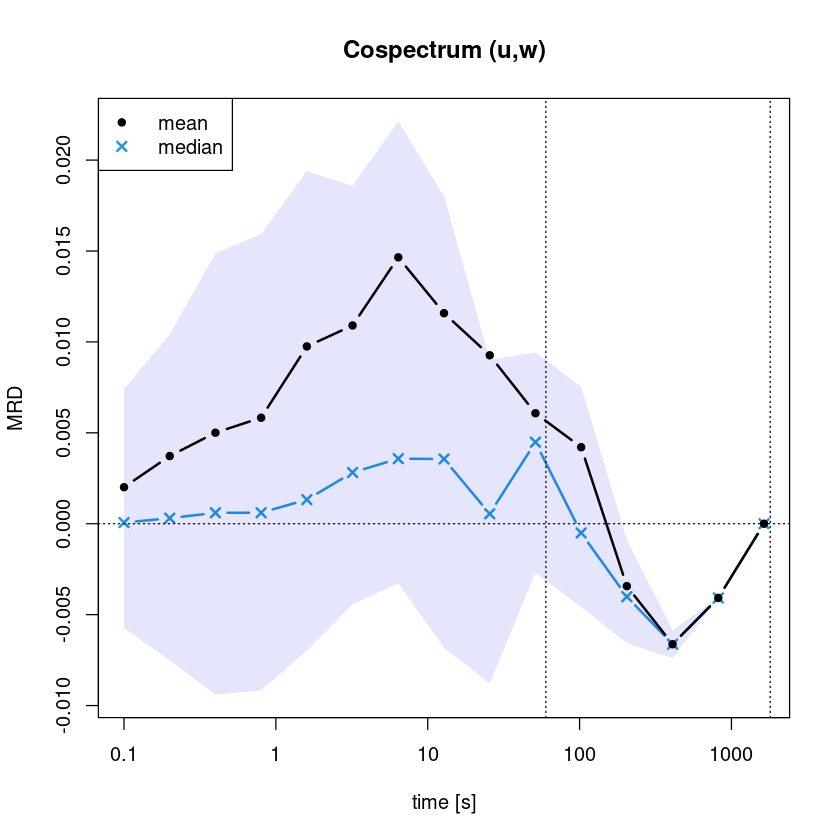

In [6]:
plot_mrd(mrd_uw, main="Cospectrum (u,w)")

In [7]:
#plot_mrd(mrd_Tw, main="Cospectrum (T,w)")

In [8]:
#plot_mrd(mrd_ww, main="Spectrum (w,w)")

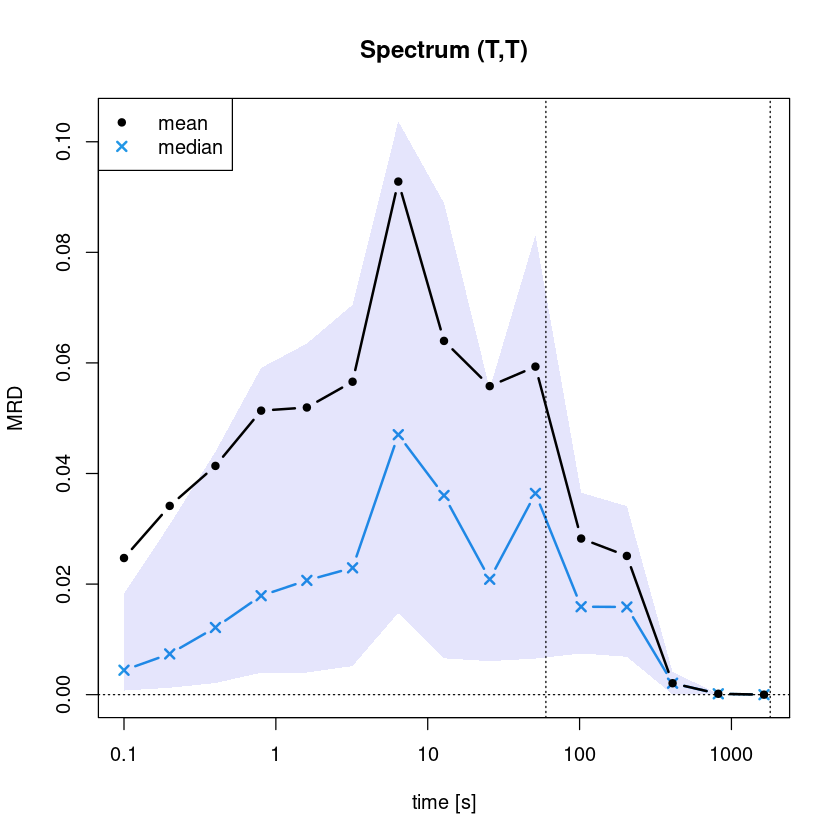

In [7]:
plot_mrd(mrd_TT, main="Spectrum (T,T)")

Composite MRDs can be created by averaging over several MRDs (also possible to distinguish different flow regimes, e.g., based on the stability parameter `calc_zeta`) and can be used to find long-term characteristic (e.g., scale gaps). Scale(s) gap(s) are defined as the the zero-crossings of the spectrum or cospectrum (larger than the first zero-crossing at the measurement frequency itself).

## Ogives
Ogives are cumulative distribution functions (calculated by integrating the spectrum). While they do not contain more information than the spectrum, the integration makes them appear smoother, which allows to estimate fluxes (and suitable averaging times) by a numerical optimization method (@Sievers2015). In Reddy, ogives are calculated by integrating a MRD:

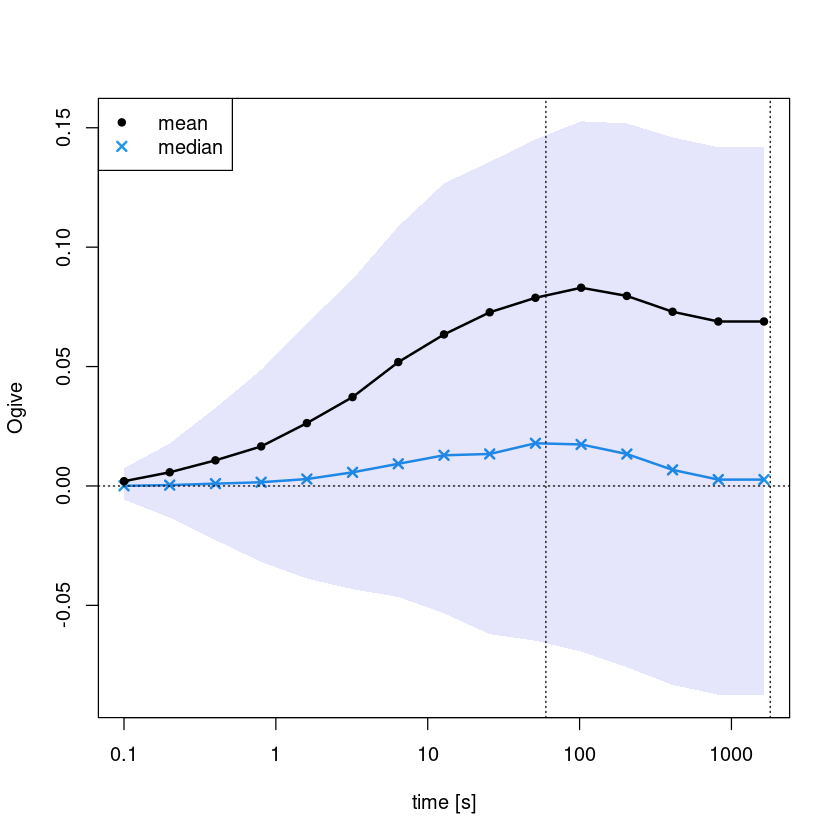

In [8]:
ogive_uw=calc_ogive(mrd_uw) #from previously calculated MRD for momentum flux

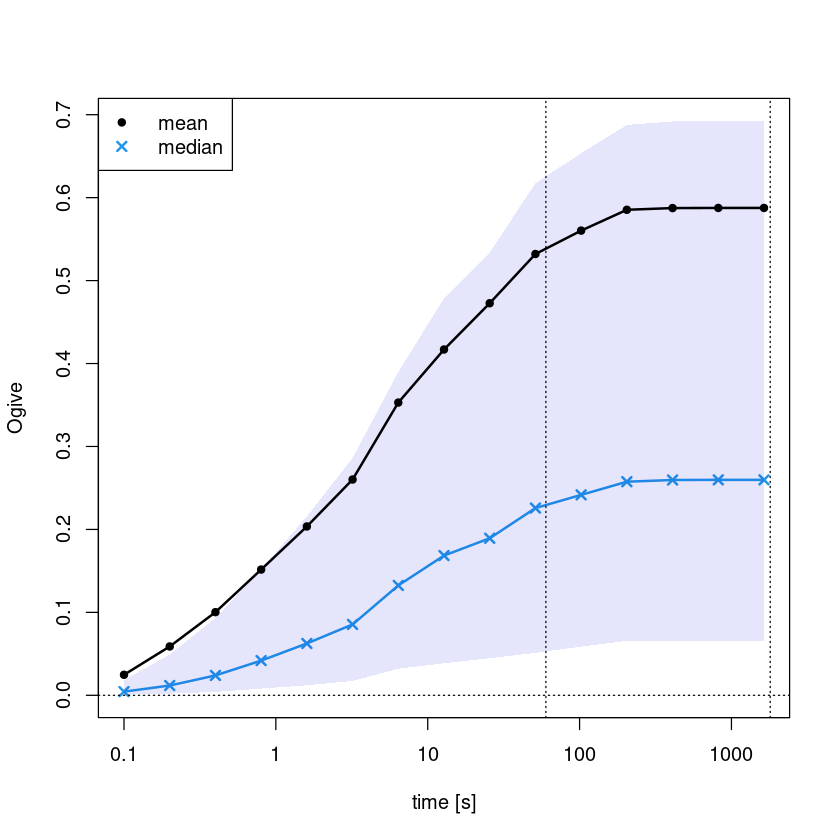

In [9]:
ogive_TT=calc_ogive(mrd_TT) #from previously calculated MRD for temperature fluctuation